In [1]:
# Cell 1: Imports and environment
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, auc
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Cell 2: Helper plotting functions
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(title)
    plt.show()

def plot_roc(y_true, y_scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.4f}")
    plt.plot([0,1],[0,1],'--', color='grey')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title(title)
    plt.legend(); plt.show()

def classification_metrics(y_true, y_pred, y_scores=None):
    print(classification_report(y_true, y_pred, digits=4))
    if y_scores is not None:
        print("ROC-AUC:", roc_auc_score(y_true, y_scores))


In [3]:
import kagglehub
import pandas as pd
import os

# Download dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Dataset downloaded to:", path)

# Load the CSV file
df = pd.read_csv(os.path.join(path, "creditcard.csv"))
df.head()

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Dataset downloaded to: /kaggle/input/creditcardfraud


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64
           count          mean           std         min           25%  \
Time    284807.0  9.481386e+04  47488.145955    0.000000  54201.500000   
V1      284807.0  1.168375e-15      1.958696  -56.407510     -0.920373   
V2      284807.0  3.416908e-16      1.651309  -72.715728     -0.598550   
V3      284807.0 -1.379537e-15      1.516255  -48.325589     -0.890365   
V4      284807.0  2.074095e-15      1.415869   -5.683171     -0.848640   
V5      284807.0  9.604066e-16      1.380247 -113.743307     -0.691597   
V6      284807.0  1.487313e-15      1.332271  -26.160506     -0.768296   
V7      284807.0 -5.556467e-16      1.237094  -43.557242     -0.554076   
V8      284807.0  1.213481e-16      1.194353  -73.216718     -0.208630   
V9      284807.0 -2.406331e-15      1.098632  -13.434066     -0.643098   
V10     284807.0  2.239053e-15      1.088850  -24.588262     -0.535426   
V11     284807.0  1.673327e-15      1.020713   -4.797473

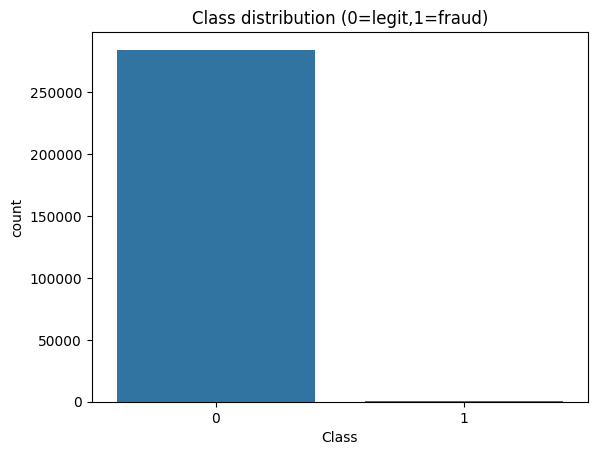

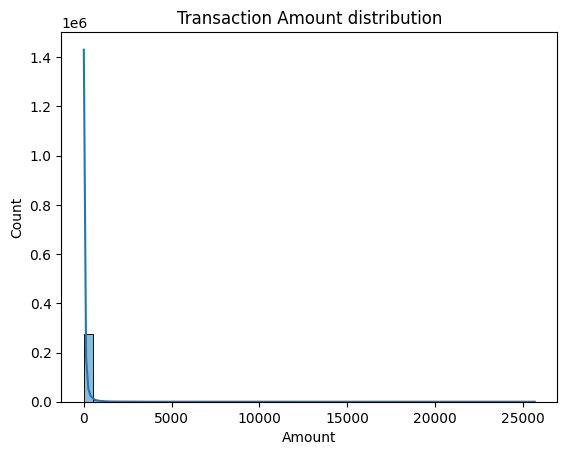

In [4]:
# Cell 4: Quick EDA
print(df['Class'].value_counts())
print(df.describe().T)
sns.countplot(x='Class', data=df)
plt.title("Class distribution (0=legit,1=fraud)")
plt.show()

# Distribution of Amount (skewed)
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Transaction Amount distribution")
plt.show()


In [5]:
# Cell 5: Feature engineering & preprocessing
# Create 'Hour' from 'Time' (seconds elapsed)
df['Hour'] = (df['Time'] // 3600) % 24
# Log1p transform for Amount
df['Amount_log'] = np.log1p(df['Amount'])

# Drop original Time/Amount if desired, keep engineered
df_model = df.drop(['Time','Amount'], axis=1)
df_model.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Hour,Amount_log
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.0,5.014760
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.0,1.305626
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0.0,5.939276
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.0,4.824306
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.0,4.262539


In [6]:
# Cell 6: Train/test split
X = df_model.drop('Class', axis=1)
y = df_model['Class']

# Standardize numerical columns (V1..V28, Hour, Amount_log)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
# Save scaler
joblib.dump(scaler, "scaler_creditcard.joblib")


Train size: (227845, 30) Test size: (56962, 30)


['scaler_creditcard.joblib']

In [7]:
# Cell 7: Handle imbalance options
# Option A: Use class_weight in the model (we will use for RandomForest)
# Option B: Use SMOTE for oversampling - show example
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train_sm))


After SMOTE: [227451 227451]


XGBoost trained
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56864
           1     0.8817    0.8367    0.8586        98

    accuracy                         0.9995     56962
   macro avg     0.9407    0.9183    0.9292     56962
weighted avg     0.9995    0.9995    0.9995     56962

ROC-AUC: 0.9675940015848772


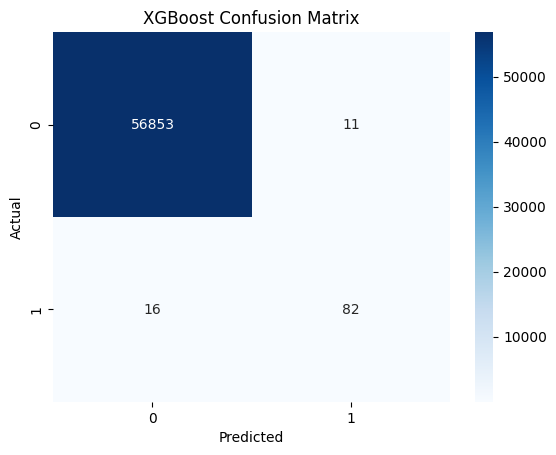

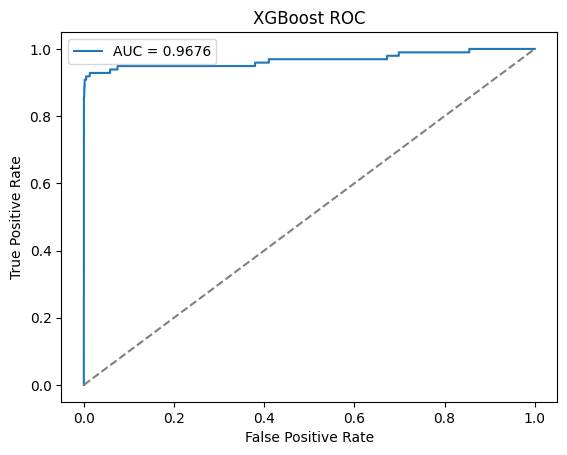

In [8]:
# Cell 8: MODEL 1 - XGBoost (or RandomForest fallback)
# We'll try XGBoost if available; else RandomForest
try:
    from xgboost import XGBClassifier
    model_xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                              use_label_encoder=False, eval_metric='auc', scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
                              random_state=42)
    model_xgb.fit(X_train, y_train)
    preds_xgb = model_xgb.predict(X_test)
    proba_xgb = model_xgb.predict_proba(X_test)[:,1]
    print("XGBoost trained")
    classification_metrics(y_test, preds_xgb, proba_xgb)
    plot_confusion_matrix(y_test, preds_xgb, "XGBoost Confusion Matrix")
    plot_roc(y_test, proba_xgb, "XGBoost ROC")
    joblib.dump(model_xgb, "xgb_creditcard.pkl")
except Exception as e:
    print("XGBoost not available or failed, falling back to RandomForest:", e)
    rf = RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample', random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    preds_rf = rf.predict(X_test)
    proba_rf = rf.predict_proba(X_test)[:,1]
    classification_metrics(y_test, preds_rf, proba_rf)
    plot_confusion_matrix(y_test, preds_rf, "RandomForest Confusion Matrix")
    plot_roc(y_test, proba_rf, "RandomForest ROC")
    joblib.dump(rf, "rf_creditcard.pkl")


In [9]:
# Cell 9: Feature importance (if RF or XGB)
try:
    imp = model_xgb.get_booster().get_score(importance_type='weight')
    # Convert to pandas
    imp_df = pd.DataFrame(list(imp.items()), columns=['feature','importance']).sort_values('importance',ascending=False)
    display(imp_df.head(10))
except:
    try:
        imp = rf.feature_importances_
        feat_names = X.columns
        imp_df = pd.DataFrame({'feature':feat_names, 'importance':imp}).sort_values('importance',ascending=False)
        display(imp_df.head(10))
    except:
        print("Feature importance not available.")


,feature,importance
13,f13,368.0
3,f3,348.0
25,f25,293.0
6,f6,292.0
9,f9,289.0
11,f11,289.0
10,f10,231.0
15,f15,230.0
29,f29,224.0
18,f18,219.0


In [10]:
# Cell 10: MODEL 2 - Autoencoder (Unsupervised anomaly detection)
# Train autoencoder only on legitimate transactions from training set
import tensorflow as tf
from tensorflow.keras import layers, Sequential, callbacks

# Separate legitimate only for training
X_train_legit = X_train[y_train==0]
print("Legit-only training shape:", X_train_legit.shape)

input_dim = X_train_legit.shape[1]
ae = Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='linear')  # linear for reconstruction
])
ae.compile(optimizer='adam', loss='mse')

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = ae.fit(X_train_legit, X_train_legit, epochs=100, batch_size=2048, validation_split=0.1, callbacks=[early_stop], verbose=1)

# Save model
ae.save("autoencoder_creditcard.h5")


Legit-only training shape: (227451, 30)
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9458 - val_loss: 0.7819
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7585 - val_loss: 0.6575
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6503 - val_loss: 0.5753
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5812 - val_loss: 0.5253
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5284 - val_loss: 0.4906
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4915 - val_loss: 0.4620
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4648 - val_loss: 0.4388
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4422 - val_loss: 0.4214
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4228 - val_loss: 0.4106
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4143 - val_loss: 0.3973
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4006 - val_loss: 0.3872
E

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 5s 726us/step
Chosen threshold: 1.4081729933945586
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step
              precision    recall  f1-score   support

           0     0.9997    0.9895    0.9946     56864
           1     0.1204    0.8367    0.2105        98

    accuracy                         0.9892     56962
   macro avg     0.5601    0.9131    0.6025     56962
weighted avg     0.9982    0.9892    0.9932     56962



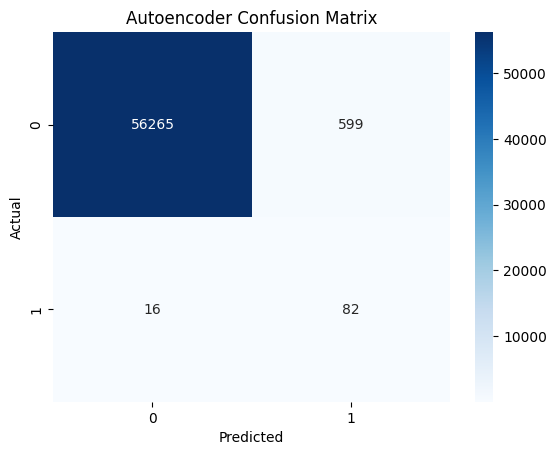

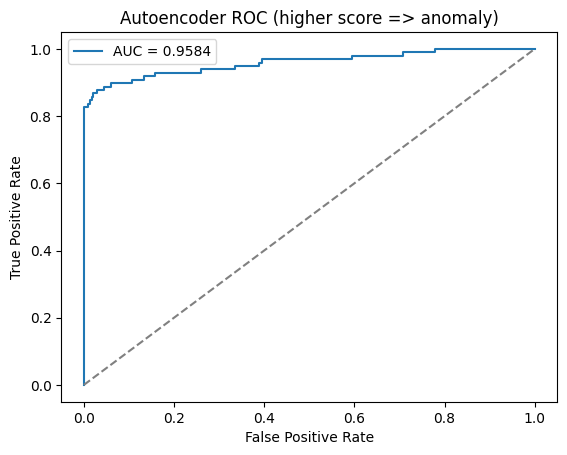

In [11]:
# Cell 11: Use autoencoder to compute reconstruction error, set threshold
# Compute MSE for test set, then pick threshold (e.g., 99th percentile of train legit errors)
recon_train = ae.predict(X_train_legit)
train_mse = np.mean(np.power(X_train_legit - recon_train, 2), axis=1)
threshold = np.percentile(train_mse, 99)  # tuneable
print("Chosen threshold:", threshold)

# Evaluate on test set
recon_test = ae.predict(X_test)
test_mse = np.mean(np.power(X_test - recon_test, 2), axis=1)
y_pred_ae = (test_mse > threshold).astype(int)

classification_metrics(y_test, y_pred_ae)
plot_confusion_matrix(y_test, y_pred_ae, "Autoencoder Confusion Matrix")
# ROC for AE (use MSE as score)
plot_roc(y_test, test_mse, "Autoencoder ROC (higher score => anomaly)")


In [12]:
# Cell 12: Compare model performance summary
# Load saved models and display a small summary
import json
results = {}
# XGB/RF results
try:
    results['xgb'] = {
        'roc_auc': float(roc_auc_score(y_test, proba_xgb)),
        'precision_recall': None
    }
except:
    results['rf'] = {
        'roc_auc': float(roc_auc_score(y_test, proba_rf)),
        'precision_recall': None
    }
results['autoencoder'] = {
    'roc_auc': float(roc_auc_score(y_test, test_mse))
}
print(json.dumps(results, indent=2))


{
  "xgb": {
    "roc_auc": 0.9675940015848772,
    "precision_recall": null
  },
  "autoencoder": {
    "roc_auc": 0.9583871076567938
  }
}


In [13]:
# Cell 13: Save scaler & a function to preprocess single transaction for demo
joblib.dump(scaler, "scaler_creditcard.joblib")
# Prepare a convenience function: expects raw features similar to original dataset (V1..V28, Amount, Time)
def preprocess_transaction(row_dict):
    # row_dict: dict with keys 'V1'...'V28', 'Amount', 'Time'
    tmp = {}
    tmp['Hour'] = (row_dict['Time'] // 3600) % 24
    tmp['Amount_log'] = np.log1p(row_dict['Amount'])
    feat_order = [f'V{i}' for i in range(1,29)] + ['Hour','Amount_log']
    arr = np.array([row_dict[f] for f in feat_order], dtype=float).reshape(1,-1)
    arr_scaled = scaler.transform(arr)
    return arr_scaled


In [14]:
# Cell 14: Load secondary dataset (IEEE-CIS) - minimal alignment & testing
# This dataset is large and complex; here we select a subset of numeric features for quick compatibility testing.
# Ensure you have train_transaction.csv and train_identity.csv in the working directory
if os.path.exists("train_transaction.csv"):
    trans = pd.read_csv("train_transaction.csv", nrows=200000)  # limit for speed; remove nrows for full
    print("IEEE-CIS sample shape:", trans.shape)
    # Basic selection: 'TransactionAmt' ~ Amount; 'TransactionDT' ~ Time; plus a few numeric columns if present
    # We'll try to extract numeric-only features and scale them to the same dimension, but note: features are different.
    # For true evaluation, implement feature mapping and feature-engineering so the features match model input.
else:
    print("No IEEE-CIS transaction file found. Download from Kaggle and place train_transaction.csv here for domain generalization tests.")


No IEEE-CIS transaction file found. Download from Kaggle and place train_transaction.csv here for domain generalization tests.


In [15]:
# Cell 15: Quick note & instructions (save)
print("Notebook progress saved. Next: tune hyperparameters, perform cross-validation, produce final plots, prepare model packaging (Gradio app and requirements.txt).")


Notebook progress saved. Next: tune hyperparameters, perform cross-validation, produce final plots, prepare model packaging (Gradio app and requirements.txt).
